In [1146]:
pip install requests


Note: you may need to restart the kernel to use updated packages.


In [1147]:
import fastf1
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import fastf1
from fastf1 import plotting
import requests
import fastf1.plotting
import seaborn as sns
from matplotlib import colormaps
from matplotlib.collections import LineCollection
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
print(fastf1.__version__)
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy import stats
import psycopg2
from sqlalchemy import create_engine


3.6.0


In [1148]:

class FastF1:
    def __init__(self, year, event_name, session_type):
        """
        Initialize FastF1 object by retrieving the session.
        """
        self.year = year
        self.session = fastf1.get_session(year, event_name, session_type)
        self.laps = None

    # ===== DATA INSPECTION ===== #

    def Load_session(self):
        """Load the session data and store laps DataFrame."""
        self.session.load()
        self.laps = self.session.laps

    def Session_event(self):
        """Return the event information object for the loaded session."""
        return self.session.event

    def Lap_info(self):
        """Show info of the laps DataFrame."""
        return self.laps.info()
        
    # ===== DATA CLEANING ===== #

    def Null_percent(self):
        """Return percentage of null values in laps."""
        return self.laps.isnull().mean() * 100

    def Drop_null(self,cols_to_drop):
        """ droping columns that containing null values more than 50 % """
        existing_cols = [col for col in cols_to_drop if col in self.laps.columns]
        self.laps.drop(existing_cols, axis=1, inplace=True)
        return self.laps

    def Filling_columns(self,columns_to_fill):
        """ filling the null values """
        for col in columns_to_fill:
            if col in self.laps.columns:
                self.laps[col].fillna(self.laps[col].mean(), inplace=True)
        return

    

    # ===== DATA ANALYSIS ===== #

    def Fastest_lap(self):
        """Return the fastest lap."""
        return self.laps.pick_fastest()

    def Value_count(self, col):
        """Return value counts of a given column in laps."""
        return self.laps[col].value_counts()

    def Stint_analysis(self, col1, col2, col3):
        """Return number of laps per driver per stint."""
        return self.laps.groupby([col1, col2])[col3].count()

    def Avg_laptime(self,col1,col2):
        """Return average lap time for each driver."""
        avg_laptime = self.laps.groupby(col1)[col2].mean()
        return avg_laptime.dt.total_seconds().sort_values()

    def Fastest_laptime(self,col1,col2,col3):
        """Return fastest lap time for each driver/team."""
        min_laptime = self.laps.groupby([col1, col2])[col3].min()
        return min_laptime.dt.total_seconds().sort_values()

    def Sector_time_comparison(self, col1, col2, col3, col4):
        """Compare fastest sector times for each driver."""
        fastest = self.laps.groupby(col1)[[col2,col3,col4]].min()
        fastest = fastest.apply(lambda x: x.dt.total_seconds())
        return fastest.sort_values(by=col2)

    def Compound_data(self):
        """Return laps with SOFT/MEDIUM/HARD compounds."""
        return self.laps[self.laps['Compound'].isin(['SOFT', 'MEDIUM', 'HARD'])][['Compound', 'TyreLife', 'FreshTyre']]

    # ===== STATISTICAL ANALYSIS ===== #
    
    def Stat_info(self):
        """ statistical information of the dataframe """
        return self.laps.describe()
    
    def Correlation_with_target(self):
        """ Correlation with the target """
        # Select only numeric columns
        numeric_cols = self.laps.select_dtypes(include=['int64', 'float64']).columns.tolist()
        target = 'TyreLife'
        correlations = []

        for col in numeric_cols:
            if col != target:  # exclude target itself
                corr_value = np.corrcoef(self.laps[col], self.laps[target])[0, 1]
                correlations.append((col, target, round(corr_value, 3)))

        # Print results nicely
        for col, tgt, corr in correlations:
            print(f"{col} vs {tgt} => correlation: {corr}")

        return 

    def Anova_with_target(self):
        
        """ Perform one-way ANOVA for all categorical variables in laps against a numeric target """
        categorical_vars = self.laps.select_dtypes(include=['object', 'category']).columns
        target = 'TyreLife'
        results = {}

        for col in categorical_vars:
            groups = [grp[target].dropna().values for _, grp in self.laps.groupby(col)]

            # Filter out empty or single-value groups
            groups = [g for g in groups if len(g) > 1]

            if len(groups) >= 2:
                f_stat, p_val = stats.f_oneway(*groups)
                print(f"ANOVA for {col}: F = {f_stat:.3f}, p = {p_val:.3e}")
                results[col] = (f_stat, p_val)
            else:
                print(f"Skipping {col}: Not enough data for ANOVA")

        return 

    def Chi_square_with_target(self):
        """ Perform Chi-Square test of independence between all categorical variables and a categorical target """
        categorical_vars = self.laps.select_dtypes(include=['object', 'category']).columns.tolist()
        target = 'Driver'
        results = []

        for col in categorical_vars:
            if col == target:
                continue

            table = pd.crosstab(self.laps[col], self.laps[target])

            if table.shape[0] > 1 and table.shape[1] > 1:
                chi2, p, dof, expected = chi2_contingency(table)
                interpretation = 'Significant' if p < 0.05 else 'Not Significant'

                results.append({
                    'Variable': col,
                    'Chi2': round(chi2, 3),
                    'p-Value': format(p, '.3e'),
                    'DF': dof,
                    'Interpretation': interpretation
                })

        return pd.DataFrame(results).sort_values(by='p-Value').reset_index(drop=True)
        

    def Detect_outliers(self,col):
        """ Detect outliers in a numeric column using the IQR (Interquartile Range) method """
        Q1 = self.laps[col].quantile(0.25)
        Q3 = self.laps[col].quantile(0.75)
        IQR = Q3 - Q1
    
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
    
        outliers = self.laps[(self.laps[col] < lower_bound) | (self.laps[col] > upper_bound)]
    
        print(f" Outlier detection for '{col}'")
        print(f"  Lower Bound : {lower_bound}")
        print(f"  Upper Bound : {upper_bound}")
        print(f"  Number of Outliers : {len(outliers)}")
    
        return
        
    # ===== VISUALIZATIONS ===== #

    def Plot_avg_tyre_life(self, col1, col2):
        """Bar chart of average tyre life by compound."""
        avg_life = self.laps.groupby(col1)[col2].mean().reset_index()
        plt.figure(figsize=(8, 5))
        sns.barplot(data=avg_life, x= col1, y= col2, palette='Set2')
        plt.title('Average Tyre Life by Compound')
        plt.ylabel('Average Tyre Life (laps)')
        plt.xlabel('Tyre Compound')
        plt.tight_layout()
        plt.show()

    def Plot_fresh_vs_used_tyres(self, col1, col2):
        """Stacked bar chart: fresh vs used tyres per compound."""
        compound_fresh_counts = self.laps.groupby([col1, col2]).size().unstack(fill_value=0)
        compound_fresh_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
        plt.title('Fresh vs Used Tyres per Compound')
        plt.xlabel('Tyre Compound')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.legend(title='Fresh Tyre (1=Fresh, 0=Used)')
        plt.tight_layout()
        plt.show()

    def Driver_position_chart(self):
        """Plot driver position changes over laps."""
        df = self.laps[self.laps['Position'].notnull()]
        plt.figure(figsize=(12, 6))
        for driver in df['Driver'].unique():
            driver_data = df[df['Driver'] == driver]
            plt.plot(driver_data['LapNumber'], driver_data['Position'], label=driver)
            plt.text(driver_data['LapNumber'].iloc[-1] + 0.2,
                     driver_data['Position'].iloc[-1],
                     driver, va='center')
        plt.gca().invert_yaxis()
        plt.xlabel("Lap")
        plt.ylabel("Position")
        plt.title(f"{self.session.event['EventName']} {self.year} - Position Changes")
        plt.tight_layout()
        plt.show()

    def Compare_speed_overlay(self, driver1, driver2):
        """Overlay comparison of speed vs distance for fastest laps of two drivers."""
        lap1 = self.laps.pick_drivers(driver1).pick_fastest()
        lap2 = self.laps.pick_drivers(driver2).pick_fastest()
        tel1 = lap1.get_car_data().add_distance()
        tel2 = lap2.get_car_data().add_distance()
        plt.figure(figsize=(12, 6))
        plt.plot(tel1['Distance'], tel1['Speed'], label=driver1)
        plt.plot(tel2['Distance'], tel2['Speed'], label=driver2)
        plt.xlabel('Distance (m)')
        plt.ylabel('Speed (km/h)')
        plt.title(f"Speed Comparison: {driver1} vs {driver2}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def Plot_fastest_lap_gear_shifts(self):
        """Plot racing line of fastest lap colored by gear shifts."""
        lap = self.laps.pick_fastest()
        tel = lap.get_telemetry()
        x, y, gear = tel['X'].values, tel['Y'].values, tel['nGear'].to_numpy().astype(float)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        cmap = cm.get_cmap('Paired')
        lc = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
        lc.set_array(gear)
        lc.set_linewidth(4)
        plt.figure(figsize=(12, 8))
        plt.gca().add_collection(lc)
        plt.axis('equal')
        plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
        plt.suptitle(f"Fastest Lap Gear Shifts\n{lap['Driver']} - {self.session.event['EventName']} {self.year}")
        cbar = plt.colorbar(lc, label="Gear", boundaries=np.arange(1, 10))
        cbar.set_ticks(np.arange(1.5, 9.5))
        cbar.set_ticklabels(np.arange(1, 9))
        plt.show()

    def Plot_driver_fastest_lap_speed(self, driver, colormap='viridis'):
        """Plot fastest lap racing line colored by speed for a driver."""
        lap = self.laps.pick_drivers(driver).pick_fastest()
        tel = lap.telemetry
        x, y, color = tel['X'].values, tel['Y'].values, tel['Speed'].values
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        fig, ax = plt.subplots(figsize=(12, 6.75))
        ax.plot(x, y, color='black', linewidth=16, zorder=0)
        norm = plt.Normalize(color.min(), color.max())
        lc = LineCollection(segments, cmap=plt.get_cmap(colormap), norm=norm, linewidth=5)
        lc.set_array(color)
        ax.add_collection(lc)
        cbar = plt.colorbar(lc, ax=ax, orientation='horizontal', pad=0.1)
        cbar.set_label('Speed (km/h)')
        ax.axis('off')
        fig.suptitle(f'{self.session.event["EventName"]} {self.year} - {driver} - Speed', size=20)
        plt.show()

    
    def Line_plot(self, col1, col2):
        """ line plot accuracy for teams performance """
        plt.figure(figsize=(15, 10))  
        sns.lineplot(data=self.laps, x= col1, y= col2)
        plt.title("IsAccurate by Team", fontsize=12) 
        return plt.show()

   
    def Scatter_plot(self, col1, col2):
        """ scatter plot for laptime vs speed """
        plt.figure(figsize=(15, 10)) 
        sns.scatterplot(data=self.laps, x= col1, y= col2)
        plt.title("Laptime vs SpeedFL", fontsize=12) 
        return plt.show()

    
    def Bar_chart(self, col1, col2):
        """ Barplot for Laps times by driver """
        plt.figure(figsize=(10, 6))
        sns.barplot(data=self.laps, x= col1, y= col2, estimator= sum)
        plt.title(" Laps times by driver")
        return plt.show()

    
    def Violin_plot(self, col1, col2):
        """ Violin position of the  drivers """
        plt.figure(figsize=(15, 10))
        sns.violinplot(data=self.laps, x= col1, y= col2)
        plt.title("position of the  drivers")
        return plt.show()
        
     
    def Bar_plot(self,col1,col2):
        """ position of the  drivers """
        plt.figure(figsize=(10, 6))
        sns.barplot(data=self.laps, x= col1, y= col2)
        plt.title(" position of the drivers")
        return plt.show()

    
    def Correlation(self,columns):
        """ heatmap for sector time """
        sns.heatmap(self.laps[columns].corr(), annot=True)
        return plt.show()

    
    def Pie_chart(self, col):
        """ pie chart for Lap Distribution by Driver """
        Driver_counts = self.laps[col].value_counts()
        plt.pie(
        Driver_counts, 
        labels=Driver_counts.index, 
        autopct='%1.1f%%', 
        startangle=140
        )
        plt.title("Lap Distribution by Driver")
        plt.axis('equal')  # Ensures the pie is circular
        plt.show()
        return

    
    def Pie_plot(self, col):
        """ pie chart for Lap Distribution by Team """
        Team_counts = self.laps[col].value_counts()
        plt.pie(
        Team_counts, 
        labels=Team_counts.index, 
        autopct='%1.1f%%', 
        startangle=140
        )
        plt.title("Lap Distribution by Team")
        plt.axis('equal')  # Ensures the pie is circular
        plt.show()
        return


    # ===== POSTGRESQL INTEGRATION ===== #

    """ Connecting python to postgresql """
    @staticmethod
    def infer_sql_type(dtype):
        if pd.api.types.is_integer_dtype(dtype):
            return "INT"
        elif pd.api.types.is_float_dtype(dtype):
            return "FLOAT"
        elif pd.api.types.is_bool_dtype(dtype):
            return "BOOLEAN"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "TIMESTAMP"
        else:
            return "TEXT"
            
            
    """ Generates SQL CREATE TABLE statement based on DataFrame column dtypes"""
    def generate_create_table_statement(self, table_name="fastf1_data"):
        """  SQL CREATE TABLE statement """
        columns = self.laps.dtypes
        sql_columns = ",\n    ".join([f'"{col}" {self.infer_sql_type(dtype)}' for col, dtype in columns.items()])
        create_stmt = f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
        {sql_columns}
        );
        """
        return create_stmt



    def save_to_postgres(self, conn_params, table_name="fastf1_data"):
        """
        Creates table and inserts DataFrame records into PostgreSQL.
        Safely converts NaN/NaT to None for compatibility with SQL.
        """
        create_stmt = self.generate_create_table_statement(table_name)
    
        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()
    
            # Create table if it doesn't exist
            cur.execute(create_stmt)
            conn.commit()
    
            # Prepare insert statement
            columns = list(self.laps.columns)
            placeholders = ', '.join(['%s'] * len(columns))
            insert_stmt = f"""
            INSERT INTO {table_name} ({', '.join(['"{}"'.format(col) for col in columns])})
            VALUES ({placeholders})
            """
    
            #  Replace NaN / NaT / numpy NaT with None
            clean_df = self.laps.astype(object).where(pd.notnull(self.laps), None)
    
            # Extra fix: ensure all datetime64[ns] NaT → None
            for col in clean_df.select_dtypes(include=["datetime64[ns]"]).columns:
                clean_df[col] = clean_df[col].apply(lambda x: x.to_pydatetime() if pd.notnull(x) else None)

            # Insert row by row
            for _, row in clean_df.iterrows():
                cur.execute(insert_stmt, tuple(row.values))
            conn.commit()
    
            cur.close()
            conn.close()
            print(f" Data inserted successfully into table {table_name}")
    
        except Exception as e:
            print(f" Error during PostgreSQL operation: {e}")




                   
    """ Reads data from a PostgreSQL table and returns a Pandas DataFrame """
    def read_from_postgresql(self, conn_params=None, table_name="fastf1_data"):
        
        if conn_params is None:
            conn_params = {
                'dbname': "postgres",
                'user': "postgres",
                'password': "postgres",
                'host': "localhost",
                'port': "5432"
            }

        try:
            conn = psycopg2.connect(**conn_params)
            query = f'SELECT * FROM {table_name}'
            df = pd.read_sql(query, conn)
            conn.close()
            return df
        except Exception as e:
            print(f" Error reading from PostgreSQL: {e}")
            return None


    

        


In [1149]:
f1 = FastF1(2021, 'Austrian Grand Prix', 'R') 

# BASIC INSPECTION

In [1150]:
f1.Load_session()

core           INFO 	Loading data for Austrian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.061000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '4', '44', '55', '11', '3', '16', '10', '14', '63', '

In [1151]:

f1.laps  # LapsDataFrame with all lap details


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:03:23.451000,VER,33,0 days 00:01:27.835000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:30.727000,...,False,Red Bull Racing,0 days 01:01:55.477000,2021-07-04 13:02:55.489,14,1.0,False,,False,False
1,0 days 01:05:15.780000,VER,33,0 days 00:01:52.329000,2.0,1.0,NaT,NaT,0 days 00:00:21.835000,0 days 00:00:54.595000,...,False,Red Bull Racing,0 days 01:03:23.451000,2021-07-04 13:04:23.463,4,1.0,False,,False,False
2,0 days 01:07:12.344000,VER,33,0 days 00:01:56.564000,3.0,1.0,NaT,NaT,0 days 00:00:26.061000,0 days 00:00:43.423000,...,False,Red Bull Racing,0 days 01:05:15.780000,2021-07-04 13:06:15.792,41,1.0,False,,False,False
3,0 days 01:08:22.143000,VER,33,0 days 00:01:09.799000,4.0,1.0,NaT,NaT,0 days 00:00:17.802000,0 days 00:00:30.663000,...,False,Red Bull Racing,0 days 01:07:12.344000,2021-07-04 13:08:12.356,1,1.0,False,,False,True
4,0 days 01:09:31.878000,VER,33,0 days 00:01:09.735000,5.0,1.0,NaT,NaT,0 days 00:00:17.619000,0 days 00:00:30.770000,...,False,Red Bull Racing,0 days 01:08:22.143000,2021-07-04 13:09:22.155,1,1.0,False,,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0 days 02:23:14.074000,MAZ,9,0 days 00:01:12.629000,66.0,3.0,NaT,NaT,0 days 00:00:17.599000,0 days 00:00:33.394000,...,True,Haas F1 Team,0 days 02:22:01.445000,2021-07-04 14:23:01.457,1,19.0,False,,False,True
1334,0 days 02:24:24.338000,MAZ,9,0 days 00:01:10.264000,67.0,3.0,NaT,NaT,0 days 00:00:17.508000,0 days 00:00:31.266000,...,True,Haas F1 Team,0 days 02:23:14.074000,2021-07-04 14:24:14.086,1,19.0,False,,False,True
1335,0 days 02:25:34.985000,MAZ,9,0 days 00:01:10.647000,68.0,3.0,NaT,NaT,0 days 00:00:17.548000,0 days 00:00:31.491000,...,True,Haas F1 Team,0 days 02:24:24.338000,2021-07-04 14:25:24.350,1,19.0,False,,False,True
1336,0 days 02:26:47.193000,MAZ,9,0 days 00:01:12.208000,69.0,3.0,NaT,NaT,0 days 00:00:17.590000,0 days 00:00:31.744000,...,True,Haas F1 Team,0 days 02:25:34.985000,2021-07-04 14:26:34.997,12,19.0,False,,False,True


In [1152]:

print(f1.Session_event())  # Prints event details


RoundNumber                                                        9
Country                                                      Austria
Location                                                   Spielberg
OfficialEventName    FORMULA 1 BWT GROSSER PREIS VON ÖSTERREICH 2021
EventDate                                        2021-07-04 00:00:00
EventName                                        Austrian Grand Prix
EventFormat                                             conventional
Session1                                                  Practice 1
Session1Date                               2021-07-02 11:30:00+02:00
Session1DateUtc                                  2021-07-02 09:30:00
Session2                                                  Practice 2
Session2Date                               2021-07-02 15:00:00+02:00
Session2DateUtc                                  2021-07-02 13:00:00
Session3                                                  Practice 3
Session3Date                      

In [1153]:
f1.Lap_info()

<class 'fastf1.core.Laps'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   Time                1338 non-null   timedelta64[ns]
 1   Driver              1338 non-null   object         
 2   DriverNumber        1338 non-null   object         
 3   LapTime             1336 non-null   timedelta64[ns]
 4   LapNumber           1338 non-null   float64        
 5   Stint               1338 non-null   float64        
 6   PitOutTime          27 non-null     timedelta64[ns]
 7   PitInTime           28 non-null     timedelta64[ns]
 8   Sector1Time         1318 non-null   timedelta64[ns]
 9   Sector2Time         1337 non-null   timedelta64[ns]
 10  Sector3Time         1336 non-null   timedelta64[ns]
 11  Sector1SessionTime  1315 non-null   timedelta64[ns]
 12  Sector2SessionTime  1337 non-null   timedelta64[ns]
 13  Sector3SessionTime  1336 non-null   timedelt

# DATA CLEANING

In [1154]:
f1.Null_percent()

Time                   0.000000
Driver                 0.000000
DriverNumber           0.000000
LapTime                0.149477
LapNumber              0.000000
Stint                  0.000000
PitOutTime            97.982063
PitInTime             97.907324
Sector1Time            1.494768
Sector2Time            0.074738
Sector3Time            0.149477
Sector1SessionTime     1.718984
Sector2SessionTime     0.074738
Sector3SessionTime     0.149477
SpeedI1               14.499253
SpeedI2                0.074738
SpeedFL                2.167414
SpeedST                0.074738
IsPersonalBest         0.000000
Compound               0.000000
TyreLife               0.000000
FreshTyre              0.000000
Team                   0.000000
LapStartTime           0.000000
LapStartDate           0.000000
TrackStatus            0.000000
Position               0.074738
Deleted                0.000000
DeletedReason          0.000000
FastF1Generated        0.000000
IsAccurate             0.000000
dtype: f

In [1155]:
cols_to_drop = ['PitOutTime', 'PitInTime', 'DeletedReason']
f1.Drop_null(cols_to_drop)

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,...,TyreLife,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,FastF1Generated,IsAccurate
0,0 days 01:03:23.451000,VER,33,0 days 00:01:27.835000,1.0,1.0,NaT,0 days 00:00:30.727000,0 days 00:00:37.013000,NaT,...,4.0,False,Red Bull Racing,0 days 01:01:55.477000,2021-07-04 13:02:55.489,14,1.0,False,False,False
1,0 days 01:05:15.780000,VER,33,0 days 00:01:52.329000,2.0,1.0,0 days 00:00:21.835000,0 days 00:00:54.595000,0 days 00:00:35.899000,0 days 01:03:45.295000,...,5.0,False,Red Bull Racing,0 days 01:03:23.451000,2021-07-04 13:04:23.463,4,1.0,False,False,False
2,0 days 01:07:12.344000,VER,33,0 days 00:01:56.564000,3.0,1.0,0 days 00:00:26.061000,0 days 00:00:43.423000,0 days 00:00:47.080000,0 days 01:05:41.850000,...,6.0,False,Red Bull Racing,0 days 01:05:15.780000,2021-07-04 13:06:15.792,41,1.0,False,False,False
3,0 days 01:08:22.143000,VER,33,0 days 00:01:09.799000,4.0,1.0,0 days 00:00:17.802000,0 days 00:00:30.663000,0 days 00:00:21.334000,0 days 01:07:30.155000,...,7.0,False,Red Bull Racing,0 days 01:07:12.344000,2021-07-04 13:08:12.356,1,1.0,False,False,True
4,0 days 01:09:31.878000,VER,33,0 days 00:01:09.735000,5.0,1.0,0 days 00:00:17.619000,0 days 00:00:30.770000,0 days 00:00:21.346000,0 days 01:08:39.771000,...,8.0,False,Red Bull Racing,0 days 01:08:22.143000,2021-07-04 13:09:22.155,1,1.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0 days 02:23:14.074000,MAZ,9,0 days 00:01:12.629000,66.0,3.0,0 days 00:00:17.599000,0 days 00:00:33.394000,0 days 00:00:21.636000,0 days 02:22:19.107000,...,21.0,True,Haas F1 Team,0 days 02:22:01.445000,2021-07-04 14:23:01.457,1,19.0,False,False,True
1334,0 days 02:24:24.338000,MAZ,9,0 days 00:01:10.264000,67.0,3.0,0 days 00:00:17.508000,0 days 00:00:31.266000,0 days 00:00:21.490000,0 days 02:23:31.645000,...,22.0,True,Haas F1 Team,0 days 02:23:14.074000,2021-07-04 14:24:14.086,1,19.0,False,False,True
1335,0 days 02:25:34.985000,MAZ,9,0 days 00:01:10.647000,68.0,3.0,0 days 00:00:17.548000,0 days 00:00:31.491000,0 days 00:00:21.608000,0 days 02:24:41.949000,...,23.0,True,Haas F1 Team,0 days 02:24:24.338000,2021-07-04 14:25:24.350,1,19.0,False,False,True
1336,0 days 02:26:47.193000,MAZ,9,0 days 00:01:12.208000,69.0,3.0,0 days 00:00:17.590000,0 days 00:00:31.744000,0 days 00:00:22.874000,0 days 02:25:52.638000,...,24.0,True,Haas F1 Team,0 days 02:25:34.985000,2021-07-04 14:26:34.997,12,19.0,False,False,True


In [1156]:
columns_to_fill = ['Sector1Time', 'Sector1SessionTime', 'SpeedI1','SpeedFL']
f1.Filling_columns(columns_to_fill)

C:\Users\rosan\AppData\Local\Temp\ipykernel_5800\3054544697.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.laps[col].fillna(self.laps[col].mean(), inplace=True)


# DATA ANALYSIS

In [1157]:
f1.Fastest_lap()

Time                      0 days 02:15:38.327000
Driver                                       VER
DriverNumber                                  33
LapTime                   0 days 00:01:06.200000
LapNumber                                   62.0
Stint                                        3.0
Sector1Time               0 days 00:00:16.806000
Sector2Time               0 days 00:00:29.330000
Sector3Time               0 days 00:00:20.064000
Sector1SessionTime        0 days 02:14:48.942000
Sector2SessionTime        0 days 02:15:18.272000
Sector3SessionTime        0 days 02:15:38.336000
SpeedI1                                    301.0
SpeedI2                                    246.0
SpeedFL                                    285.0
SpeedST                                    303.0
IsPersonalBest                              True
Compound                                    HARD
TyreLife                                     2.0
FreshTyre                                   True
Team                

In [1158]:
f1.Value_count("Compound")

Compound
HARD      850
MEDIUM    432
SOFT       56
Name: count, dtype: int64

In [1159]:
f1.Stint_analysis('Driver','Stint','LapNumber')

Driver  Stint
ALO     1.0      32
        2.0      38
BOT     1.0      30
        2.0      41
GAS     1.0      13
        2.0      32
        3.0      26
GIO     1.0       1
        2.0      28
        3.0      41
HAM     1.0      31
        2.0      22
        3.0      18
LAT     1.0      33
        2.0      37
LEC     1.0      34
        2.0      37
MAZ     1.0      27
        2.0      18
        3.0      24
MSC     1.0      34
        2.0      35
NOR     1.0      30
        2.0      41
OCO     1.0       1
PER     1.0      32
        2.0      39
RAI     1.0      37
        2.0      33
RIC     1.0      29
        2.0      42
RUS     1.0      30
        2.0      40
SAI     1.0      48
        2.0      23
STR     1.0      14
        2.0      32
        3.0      24
TSU     1.0      12
        2.0      39
        3.0      19
VER     1.0      32
        2.0      28
        3.0      11
VET     1.0      17
        2.0      32
        3.0      21
Name: LapNumber, dtype: int64

In [1160]:
f1.Avg_laptime("Driver","LapTime")

Driver
VER    70.909056
BOT    71.162197
NOR    71.191014
HAM    71.563310
PER    71.583915
SAI    71.713901
RIC    71.759690
LEC    71.770958
GAS    71.780099
ALO    72.079814
RUS    72.160271
VET    72.204159
TSU    72.242314
STR    72.337429
GIO    72.450871
LAT    72.540629
RAI    72.563400
MSC    73.050826
MAZ    73.790971
OCO          NaN
Name: LapTime, dtype: float64

In [1161]:
f1.Fastest_laptime('Driver','Team','LapTime')

Driver  Team             
VER     Red Bull Racing      66.200
SAI     Ferrari              67.762
HAM     Mercedes             68.126
GAS     AlphaTauri           68.146
PER     Red Bull Racing      68.192
BOT     Mercedes             68.374
ALO     Alpine               68.405
VET     Aston Martin         68.420
TSU     AlphaTauri           68.455
NOR     McLaren              68.471
RAI     Alfa Romeo Racing    68.520
STR     Aston Martin         68.659
LEC     Ferrari              68.698
RIC     McLaren              68.820
LAT     Williams             68.874
RUS     Williams             68.900
GIO     Alfa Romeo Racing    69.042
MSC     Haas F1 Team         69.394
MAZ     Haas F1 Team         69.757
OCO     Alpine                  NaN
Name: LapTime, dtype: float64

In [1162]:
f1.Sector_time_comparison('Driver','Sector1Time', 'Sector2Time', 'Sector3Time')

,Sector1Time,Sector2Time,Sector3Time
Driver,,,
VER,16.749000,29.330,20.064
GAS,16.772000,30.341,20.515
STR,16.816000,30.508,20.681
PER,16.854000,30.184,20.542
NOR,16.890000,30.251,20.526
VET,16.929000,30.265,20.686
ALO,16.957000,30.505,20.525
SAI,16.961000,30.269,20.439
LEC,16.972000,30.367,20.729


In [1163]:
f1.Compound_data()

,Compound,TyreLife,FreshTyre
0,MEDIUM,4.0,False
1,MEDIUM,5.0,False
2,MEDIUM,6.0,False
3,MEDIUM,7.0,False
4,MEDIUM,8.0,False
...,...,...,...
1333,HARD,21.0,True
1334,HARD,22.0,True
1335,HARD,23.0,True
1336,HARD,24.0,True


# STATISTICAL ANALYSIS

In [1164]:
f1.Stat_info()

,Time,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,TyreLife,LapStartTime,LapStartDate,Position
count,1338,1336,1338.000000,1338.000000,1338,1337,1336,1338,1337,1336,1338.000000,1337.000000,1338.000000,1337.000000,1338.000000,1338,1338,1337.000000
mean,0 days 01:45:49.848188340,0 days 00:01:12.039091317,35.661435,1.751121,0 days 00:00:18.024683611,0 days 00:00:31.727727748,0 days 00:00:22.252965568,0 days 01:45:31.593571863,0 days 01:45:29.514023934,0 days 01:45:49.933135479,296.895979,227.432311,272.301757,294.666417,17.301943,0 days 01:44:37.754497757,2021-07-04 13:45:37.766497536,9.953628
min,0 days 01:03:23.451000,0 days 00:01:06.200000,1.000000,1.000000,0 days 00:00:16.749000,0 days 00:00:29.330000,0 days 00:00:20.064000,0 days 01:03:45.295000,0 days 01:02:46.483000,0 days 01:03:23.665000,133.000000,54.000000,111.000000,112.000000,1.000000,0 days 01:01:55.477000,2021-07-04 13:02:55.489000,1.000000
25%,0 days 01:25:12.819000,0 days 00:01:09.234000,18.000000,1.000000,0 days 00:00:17.318500,0 days 00:00:30.874000,0 days 00:00:20.966250,0 days 01:25:33.182750,0 days 01:24:53.617000,0 days 01:25:14.477500,293.000000,225.000000,272.000000,291.000000,9.000000,0 days 01:24:00.064750,2021-07-04 13:25:00.076750080,5.000000
50%,0 days 01:46:04.267000,0 days 00:01:09.995500,36.000000,2.000000,0 days 00:00:17.466000,0 days 00:00:31.245000,0 days 00:00:21.250000,0 days 01:45:31.593571863,0 days 01:45:46.325000,0 days 01:46:04.332000,296.895979,229.000000,275.000000,296.000000,16.000000,0 days 01:44:53.706000,2021-07-04 13:45:53.717999872,10.000000
75%,0 days 02:06:37.970250,0 days 00:01:11.098000,53.000000,2.000000,0 days 00:00:17.619750,0 days 00:00:31.758000,0 days 00:00:21.736750,0 days 02:05:40.447750,0 days 02:06:17.990000,0 days 02:06:36.482750,302.000000,234.000000,278.000000,302.000000,25.000000,0 days 02:05:28.758750,2021-07-04 14:06:28.770749952,15.000000
max,0 days 02:27:04.220000,0 days 00:02:00.589000,71.000000,3.000000,0 days 00:00:40.247000,0 days 00:01:06.390000,0 days 00:00:58.776000,0 days 02:25:58.707000,0 days 02:26:30.657000,0 days 02:26:52.003000,331.000000,246.000000,289.000000,332.000000,48.000000,0 days 02:25:41.935000,2021-07-04 14:26:41.947000,19.000000
std,0 days 00:23:57.485813848,0 days 00:00:07.949566020,20.339115,0.679942,0 days 00:00:02.780391959,0 days 00:00:02.617388284,0 days 00:00:04.430079561,0 days 00:23:23.246399911,0 days 00:23:58.093352222,0 days 00:23:55.272299341,16.839615,14.743671,19.238918,21.252461,10.313559,0 days 00:24:00.714987244,NaN,5.474295


In [1165]:
f1.Correlation_with_target()

LapNumber vs TyreLife => correlation: 0.425
Stint vs TyreLife => correlation: -0.1
SpeedI1 vs TyreLife => correlation: 0.149
SpeedI2 vs TyreLife => correlation: nan
SpeedFL vs TyreLife => correlation: 0.229
SpeedST vs TyreLife => correlation: nan
Position vs TyreLife => correlation: nan


In [1166]:
f1.Anova_with_target()

ANOVA for Driver: F = 4.954, p = 5.391e-11
ANOVA for DriverNumber: F = 4.954, p = 5.391e-11
ANOVA for Compound: F = 12.458, p = 4.359e-06
ANOVA for Team: F = 6.322, p = 8.345e-09
ANOVA for TrackStatus: F = 31.562, p = 1.875e-30


In [1167]:
f1.Chi_square_with_target()

,Variable,Chi2,p-Value,DF,Interpretation
0,DriverNumber,25422.000,0.000e+00,361,Significant
1,Team,12042.000,0.000e+00,171,Significant
2,Compound,409.978,6.591e-64,38,Significant
3,TrackStatus,82.825,8.093e-01,95,Not Significant


In [1168]:
f1.Detect_outliers("TyreLife")

 Outlier detection for 'TyreLife'
  Lower Bound : -15.0
  Upper Bound : 49.0
  Number of Outliers : 0


# VISUALIZATIONS

C:\Users\rosan\AppData\Local\Temp\ipykernel_5800\3054544697.py:177: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_life, x= col1, y= col2, palette='Set2')


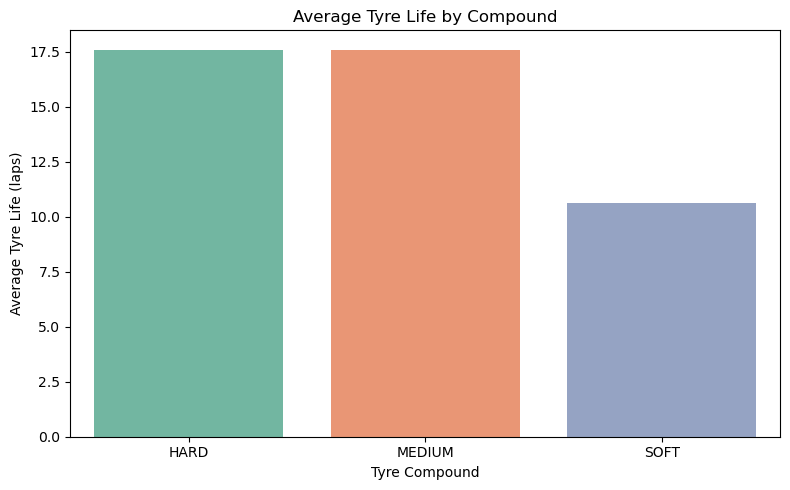

In [1169]:
f1.Plot_avg_tyre_life('Compound','TyreLife')

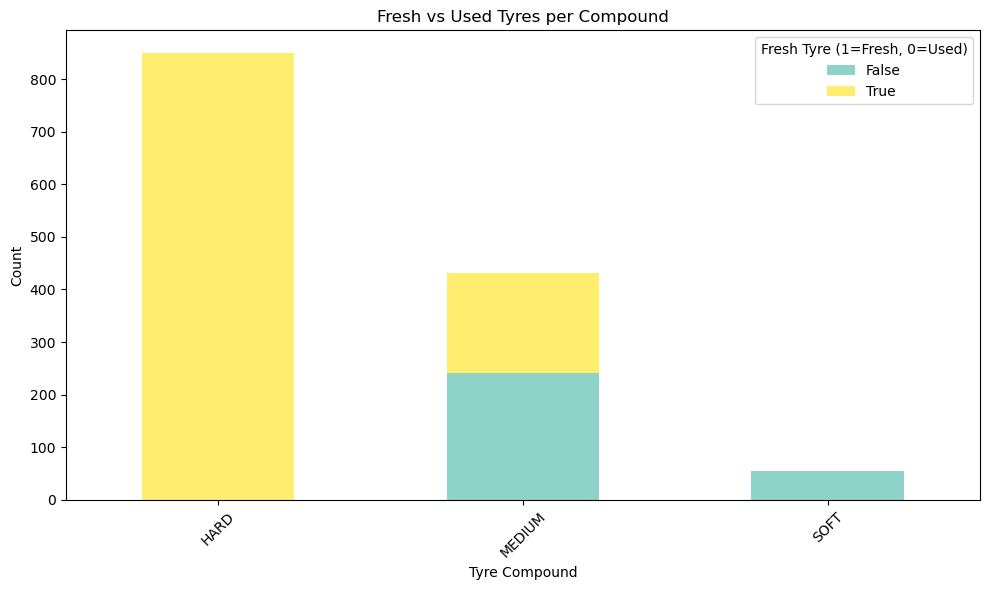

In [1170]:
f1.Plot_fresh_vs_used_tyres('Compound','FreshTyre')

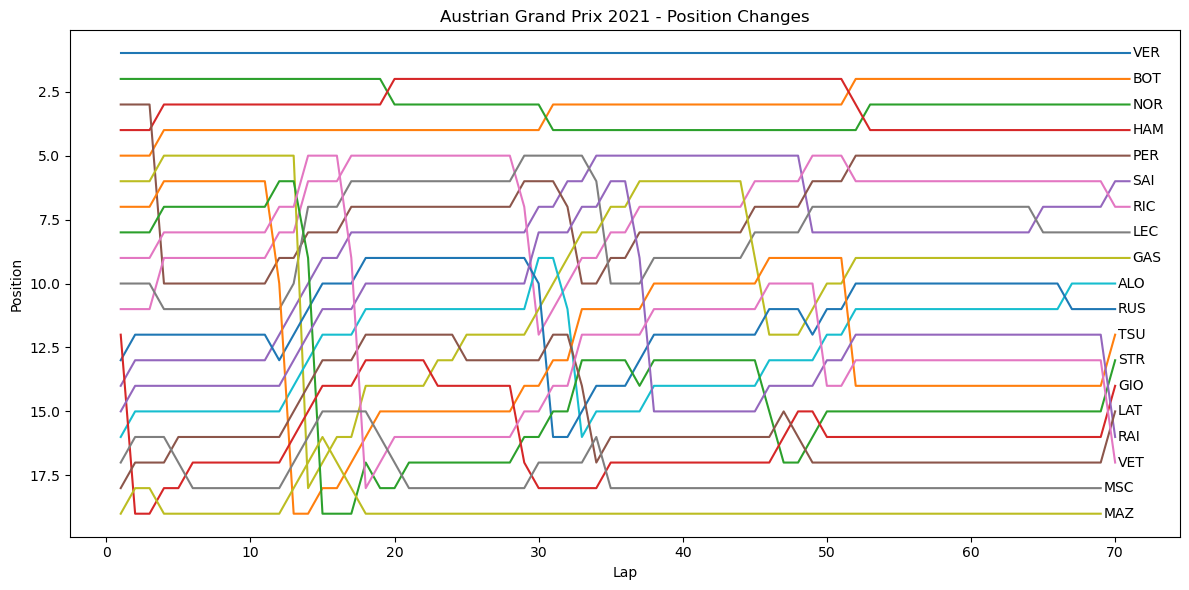

In [1171]:
f1.Driver_position_chart()

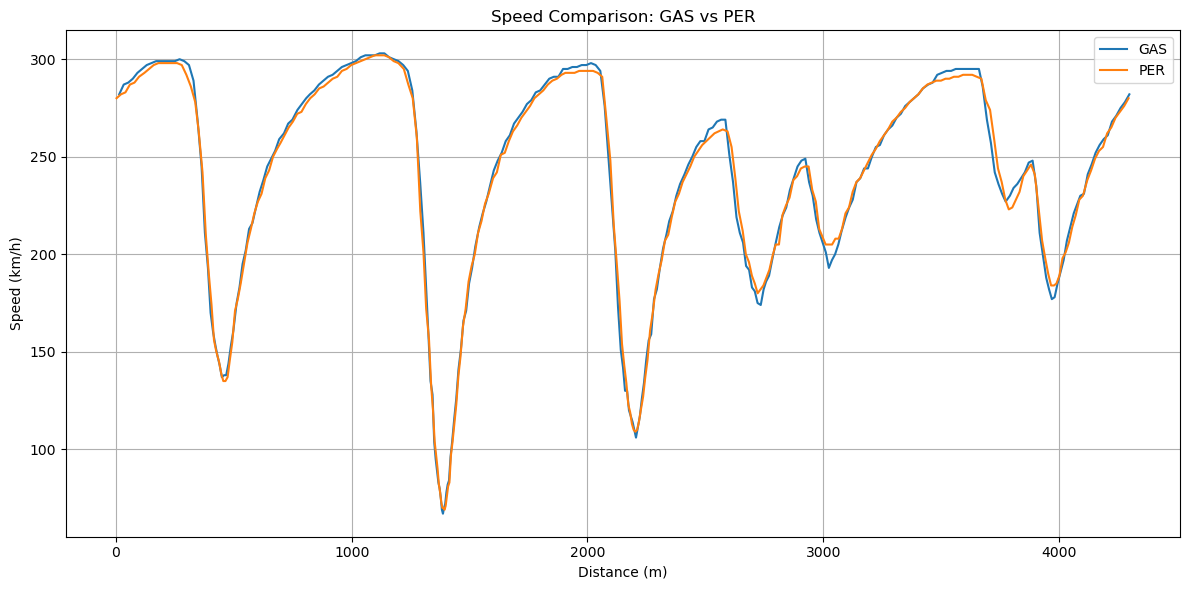

In [1172]:
f1.Compare_speed_overlay("GAS","PER")

C:\Users\rosan\AppData\Local\Temp\ipykernel_5800\3054544697.py:237: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Paired')


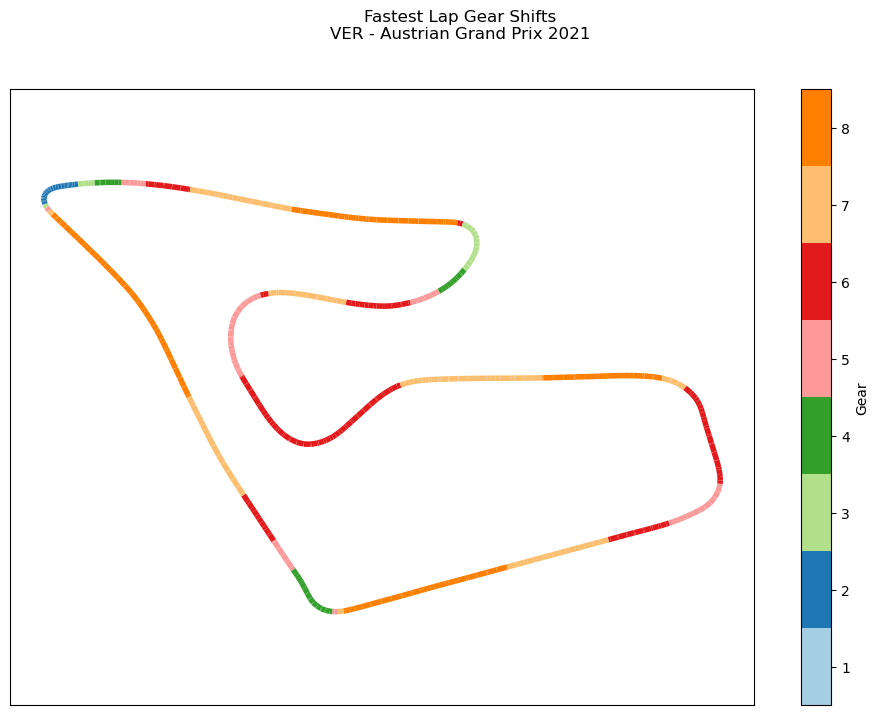

In [1173]:
f1.Plot_fastest_lap_gear_shifts() # Fastest lap gear shift visualization

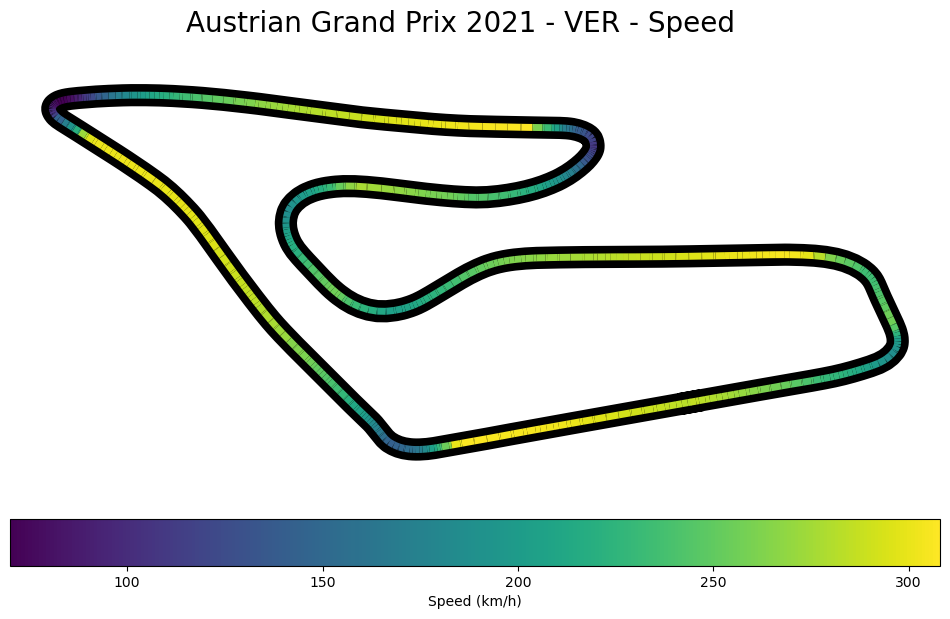

In [1174]:
f1.Plot_driver_fastest_lap_speed('VER')

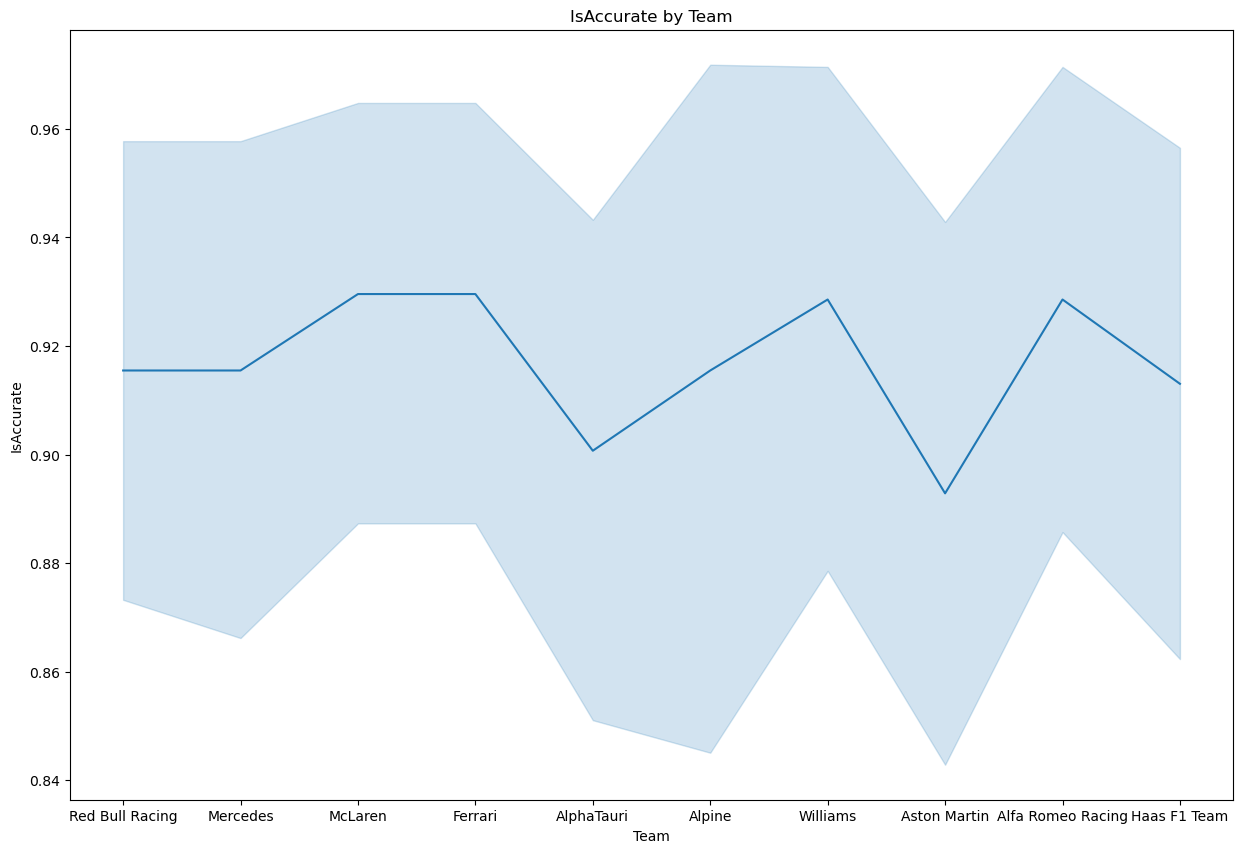

In [1175]:
f1.Line_plot("Team", "IsAccurate")

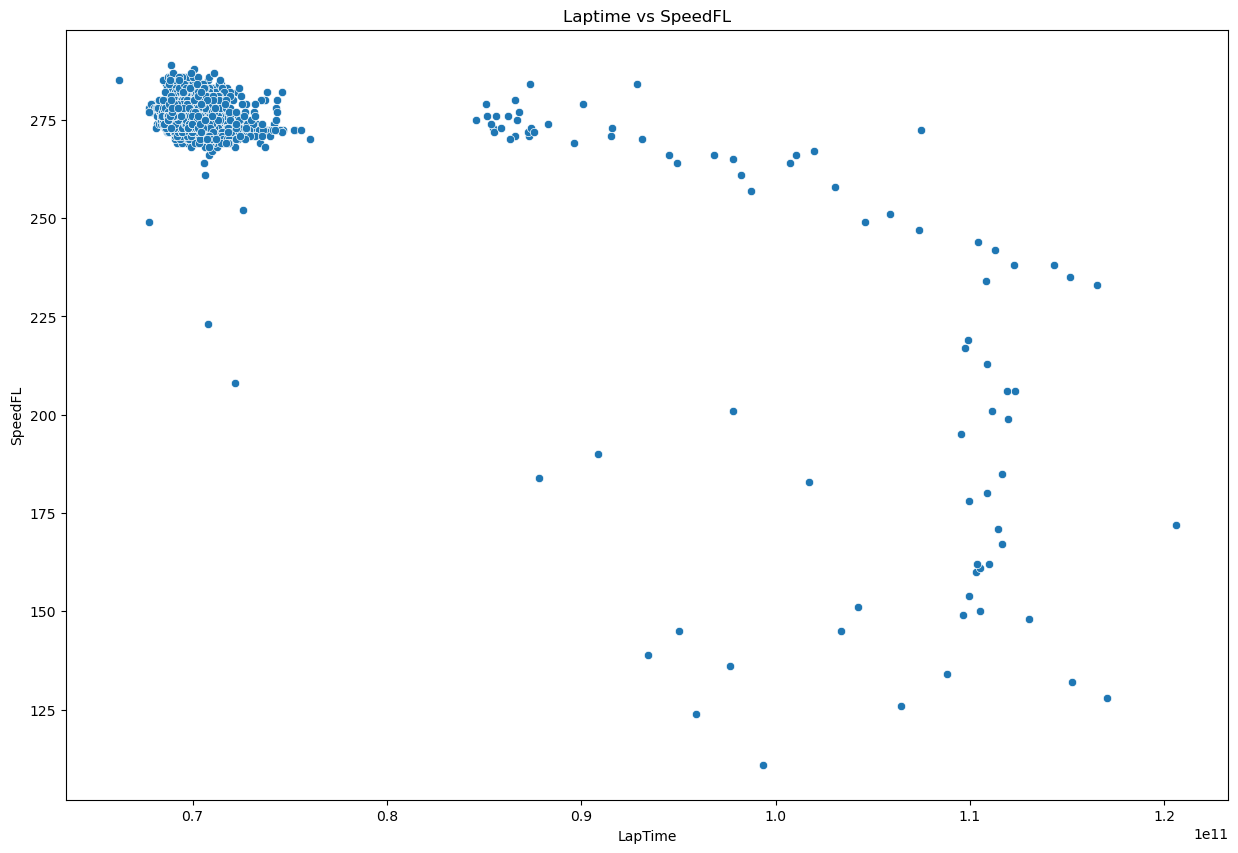

In [1176]:
f1.Scatter_plot("LapTime","SpeedFL")

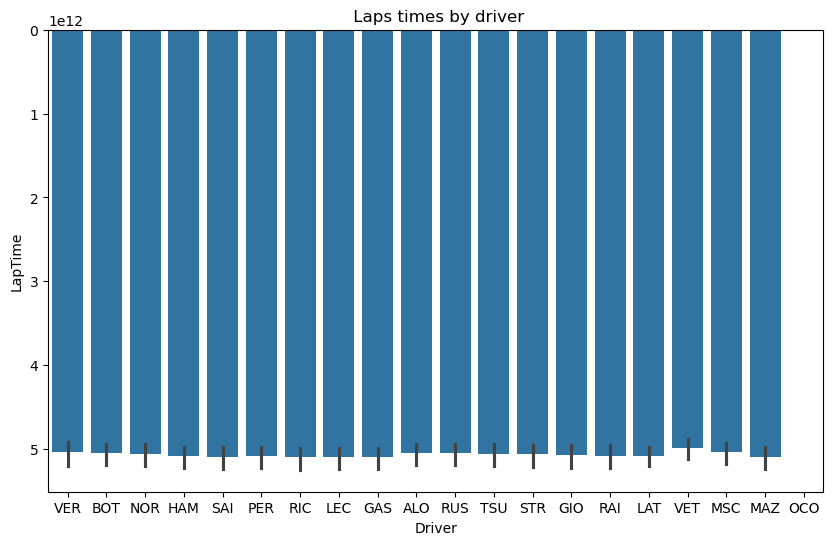

In [1177]:
f1.Bar_chart("Driver","LapTime")

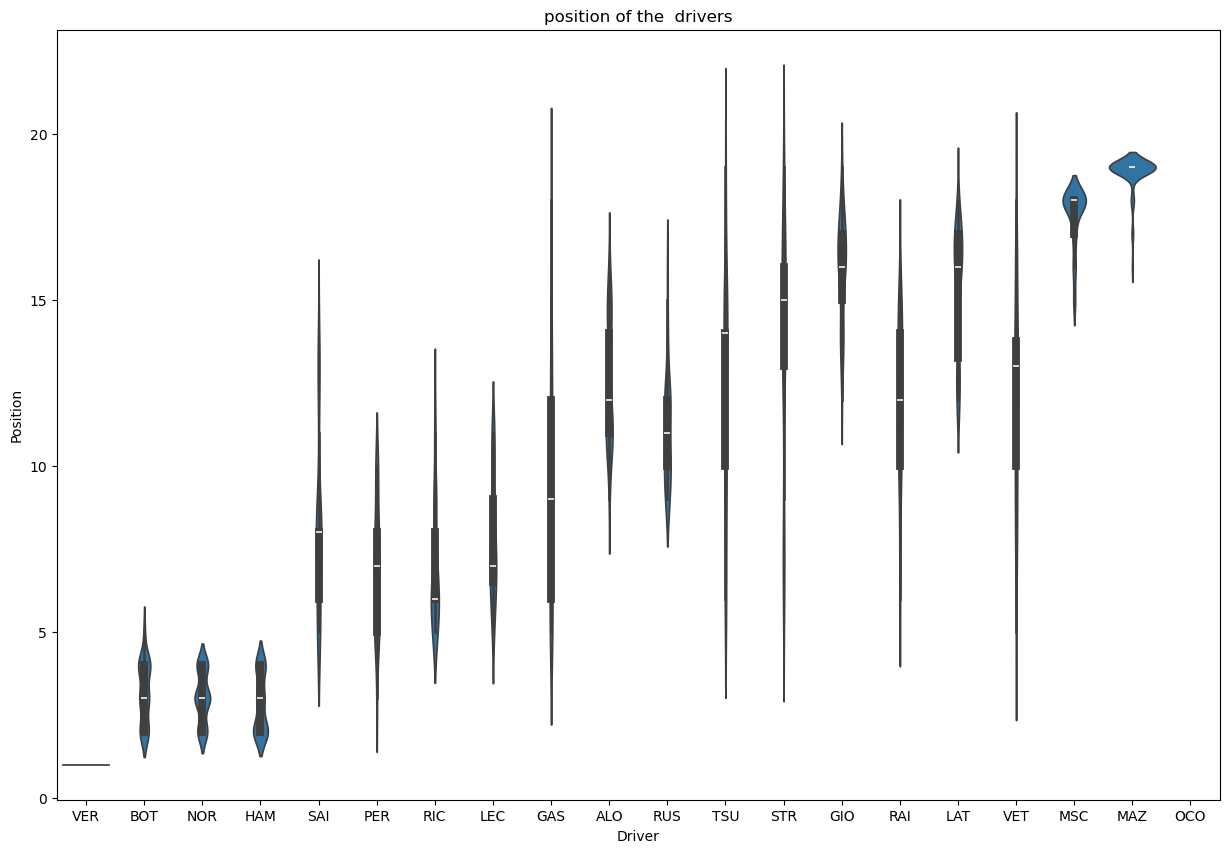

In [1178]:
f1.Violin_plot("Driver", "Position")


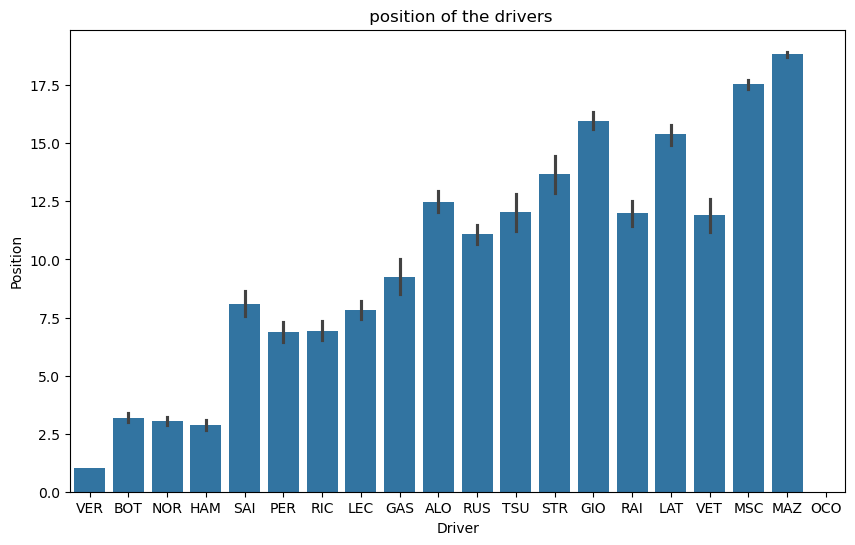

In [1179]:
f1.Bar_plot("Driver","Position")

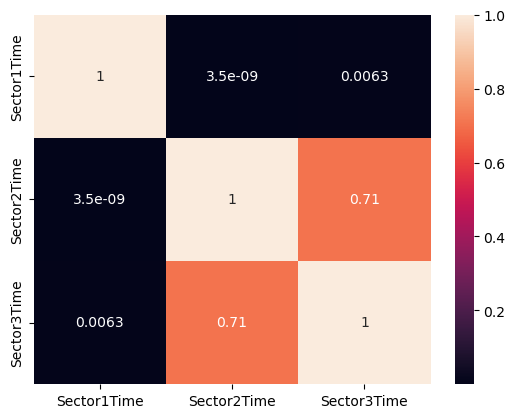

In [1180]:
columns = ['Sector1Time','Sector2Time','Sector3Time']
f1.Correlation(columns)

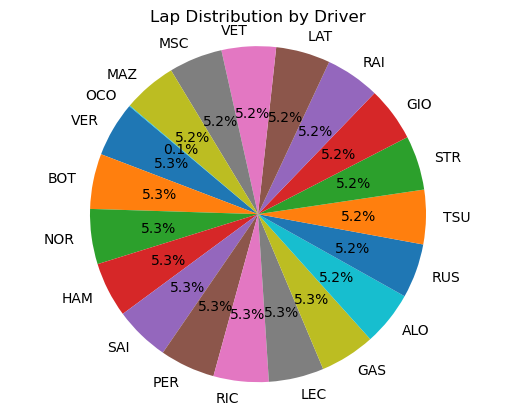

In [1181]:
f1.Pie_chart("Driver")

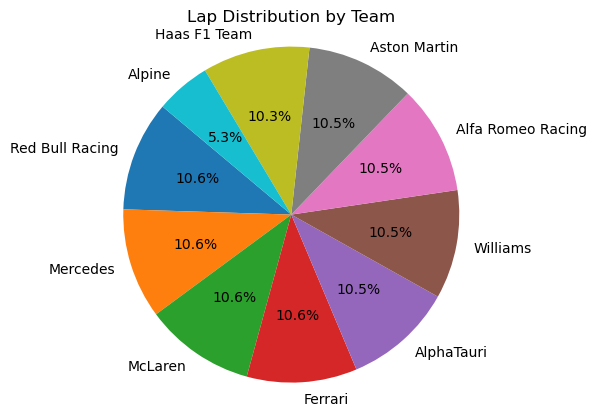

In [1182]:
f1.Pie_plot("Team")

# Connecting python to postgresql

In [1183]:
print(f1.generate_create_table_statement())


        CREATE TABLE IF NOT EXISTS fastf1_data (
        "Time" TEXT,
    "Driver" TEXT,
    "DriverNumber" TEXT,
    "LapTime" TEXT,
    "LapNumber" FLOAT,
    "Stint" FLOAT,
    "Sector1Time" TEXT,
    "Sector2Time" TEXT,
    "Sector3Time" TEXT,
    "Sector1SessionTime" TEXT,
    "Sector2SessionTime" TEXT,
    "Sector3SessionTime" TEXT,
    "SpeedI1" FLOAT,
    "SpeedI2" FLOAT,
    "SpeedFL" FLOAT,
    "SpeedST" FLOAT,
    "IsPersonalBest" BOOLEAN,
    "Compound" TEXT,
    "TyreLife" FLOAT,
    "FreshTyre" BOOLEAN,
    "Team" TEXT,
    "LapStartTime" TEXT,
    "LapStartDate" TIMESTAMP,
    "TrackStatus" TEXT,
    "Position" FLOAT,
    "Deleted" BOOLEAN,
    "FastF1Generated" BOOLEAN,
    "IsAccurate" BOOLEAN
        );
        


In [1184]:
# Inserting data into postgresql database
conn_params = {
    'dbname': "postgres",
    'user': "postgres",
    'password': "postgres",
    'host': "localhost",
    'port': "5432"
}
f1.save_to_postgres(conn_params, table_name="fastf1_data")

 Data inserted successfully into table fastf1_data


# Connecting postgresql to python

In [1185]:
# Reading the data from postgresql to python
conn_params = {
    'dbname': "postgres",
    'user': "postgres",
    'password': "postgres",
    'host': "localhost",
    'port': "5432"
}
f1.read_from_postgresql(conn_params, "fastf1_data")


C:\Users\rosan\AppData\Local\Temp\ipykernel_5800\3054544697.py:439: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,...,TyreLife,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,FastF1Generated,IsAccurate
0,00:35:12.805,VER,33,00:01:46.339,1.0,1.0,00:00:25.532648,00:00:29.563,00:00:44.929,01:18:15.36436,...,4.0,False,Red Bull Racing,00:33:26.312,2021-06-20 13:03:26.320,1,2.0,False,False,False
1,00:36:52.418,VER,33,00:01:39.613,2.0,1.0,00:00:25.323,00:00:29.545,00:00:44.745,00:35:38.134,...,5.0,False,Red Bull Racing,00:35:12.805,2021-06-20 13:05:12.813,1,2.0,False,False,True
2,00:38:31.989,VER,33,00:01:39.571,3.0,1.0,00:00:25.417,00:00:29.755,00:00:44.399,00:37:17.841,...,6.0,False,Red Bull Racing,00:36:52.418,2021-06-20 13:06:52.426,1,2.0,False,False,True
3,00:40:12.013,VER,33,00:01:40.024,4.0,1.0,00:00:25.489,00:00:29.675,00:00:44.86,00:38:57.484,...,7.0,False,Red Bull Racing,00:38:31.989,2021-06-20 13:08:31.997,1,2.0,False,False,True
4,00:41:51.421,VER,33,00:01:39.408,5.0,1.0,00:00:25.362,00:00:29.678,00:00:44.368,00:40:37.381,...,8.0,False,Red Bull Racing,00:40:12.013,2021-06-20 13:10:12.021,1,2.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39456,02:23:14.074,MAZ,9,00:01:12.629,66.0,3.0,00:00:17.599,00:00:33.394,00:00:21.636,02:22:19.107,...,21.0,True,Haas F1 Team,02:22:01.445,2021-07-04 14:23:01.457,1,19.0,False,False,True
39457,02:24:24.338,MAZ,9,00:01:10.264,67.0,3.0,00:00:17.508,00:00:31.266,00:00:21.49,02:23:31.645,...,22.0,True,Haas F1 Team,02:23:14.074,2021-07-04 14:24:14.086,1,19.0,False,False,True
39458,02:25:34.985,MAZ,9,00:01:10.647,68.0,3.0,00:00:17.548,00:00:31.491,00:00:21.608,02:24:41.949,...,23.0,True,Haas F1 Team,02:24:24.338,2021-07-04 14:25:24.350,1,19.0,False,False,True
39459,02:26:47.193,MAZ,9,00:01:12.208,69.0,3.0,00:00:17.59,00:00:31.744,00:00:22.874,02:25:52.638,...,24.0,True,Haas F1 Team,02:25:34.985,2021-07-04 14:26:34.997,12,19.0,False,False,True
